<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/Depth_DPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download Dataset

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

ids = ['1Q45JutY3Fu4wqf4z_Xarz6CTJnyofnSx']
zip_files = ['instrument17_valid.zip']
for id, zip_file in zip(ids, zip_files):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(zip_file)
    if zip_file[-3:] == 'zip':
        !unzip -q $zip_file

Installation

In [7]:
!pip -q install transformers

DPT

In [3]:
from transformers import DPTFeatureExtractor, DPTForDepthEstimation
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")
depth_estimation = DPTForDepthEstimation.from_pretrained("Intel/dpt-large").to(device)

/usr/local/lib/python3.10/dist-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
from glob import glob
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import tifffile
import cv2
import gdown
import os

class TestDataset(Dataset):
    def __init__(self, path_depth=None, transform=None):
        self.path_depth = path_depth
        self.transform = transform

    def __len__(self):
      return len(self.path_depth)   

    def __getitem__(self, i):
        # depth = tifffile.imread(self.path_depth[i])[:,:,2]
        img = Image.open(self.path_depth[i]).convert('RGB')
        # img = Image.open(path_[:-14] + 'Image.png').convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

#(1024, 1280, 3)
transform_test = transforms.Compose([
    transforms.Resize((256, 320)), 
    transforms.ToTensor(),    
])

data_root_dir = 'instrument17_valid/**/images/'
img_dir = glob(data_root_dir + '*.jpg')
dataset_test = TestDataset(path_depth=img_dir, transform=transform_test)
print('test sample:', len(dataset_test))

test sample: 450


V0: From Lib Directly

(640, 800, 3)
torch.Size([1, 3, 384, 384])


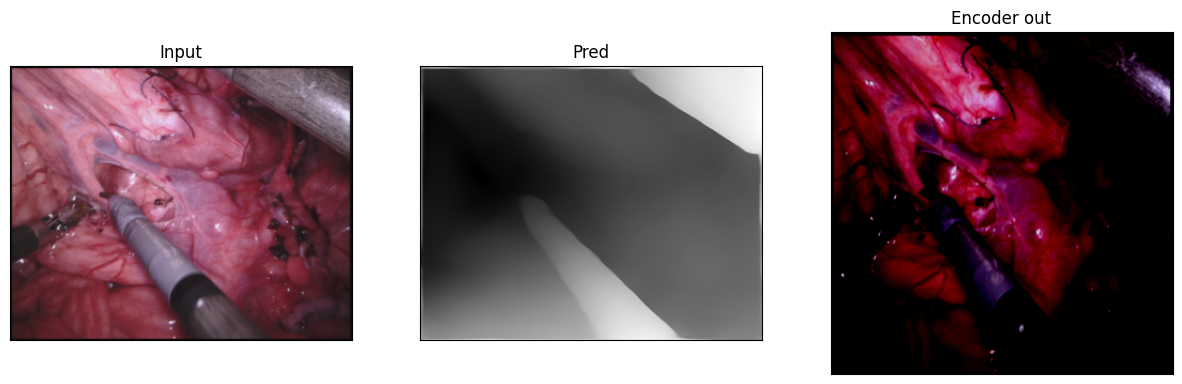

In [9]:
image_raw = transforms.ToPILImage()(dataset_test[0])#[None]
image = image_raw.resize((800, int(800 * image_raw.size[1] / image_raw.size[0])), Image.LANCZOS)# Image.Resampling.LANCZOS)
print(np.array(image).shape)
encoding = feature_extractor(image, return_tensors="pt").to(device)
print(encoding['pixel_values'].shape)
with torch.no_grad():
    outputs = depth_estimation(**encoding)
    # print(outputs.__dict__.keys())#['loss', 'predicted_depth', 'hidden_states', 'attentions']
    predicted_depth = outputs.predicted_depth
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image_raw.size[::-1],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
output = prediction.cpu().numpy() 

num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(dataset_test[0].permute(1,2,0))
ax[0].set_title('Input')
ax[1].imshow(output, cmap='gray')
ax[1].set_title('Pred');
ax[2].imshow(encoding['pixel_values'][0].permute(1,2,0).cpu(), cmap='gray')
ax[2].set_title('Encoder out');

V1: Simplest

(640, 800, 3)
torch.Size([1, 3, 384, 384])


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


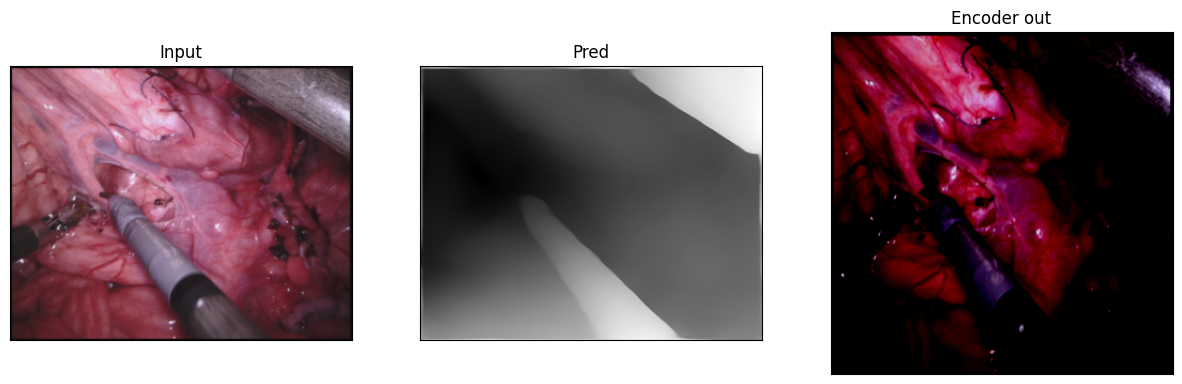

In [11]:
import torch
from torch import nn
from transformers import DPTFeatureExtractor, DPTForDepthEstimation, DPTConfig
#depth_estimation = DPTForDepthEstimation.from_pretrained("Intel/dpt-large").to(device)
class DPT_CUSTOM(nn.Module):
    def __init__(self,):
        super(DPT_CUSTOM, self).__init__()
        self.dpt = DPTForDepthEstimation.from_pretrained("Intel/dpt-large").to(device)

    def forward(self, inputs):
        outputs = self.dpt (inputs)
        return outputs



image_raw = transforms.ToPILImage()(dataset_test[0])#[None]
image = image_raw.resize((800, int(800 * image_raw.size[1] / image_raw.size[0])), Image.LANCZOS)# Image.Resampling.LANCZOS)
print(np.array(image).shape)
encoding = feature_extractor(image, return_tensors="pt").to(device)
print(encoding['pixel_values'].shape)

depth_estimation_custom = DPT_CUSTOM()

with torch.no_grad():
    #outputs = depth_estimation(**encoding)
    outputs = depth_estimation_custom(encoding['pixel_values'])
    predicted_depth = outputs.predicted_depth
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image_raw.size[::-1],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
output = prediction.cpu().numpy() 

num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(dataset_test[0].permute(1,2,0))
ax[0].set_title('Input')
ax[1].imshow(output, cmap='gray')
ax[1].set_title('Pred');
ax[2].imshow(encoding['pixel_values'][0].permute(1,2,0).cpu(), cmap='gray')
ax[2].set_title('Encoder out');

V2: Medium

(640, 800, 3)
torch.Size([1, 3, 384, 384])


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


input torch.Size([1, 3, 384, 384])
embedded output: torch.Size([1, 577, 1024])
encoder output torch.Size([1, 577, 1024])


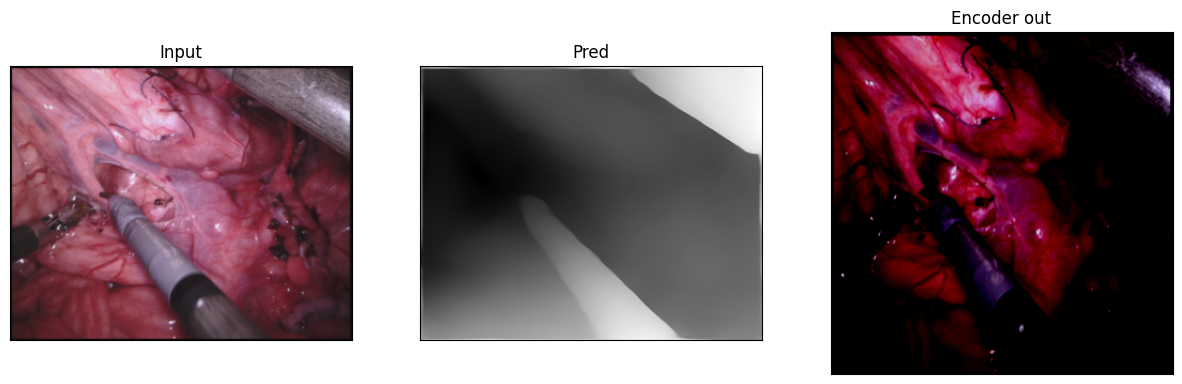

In [30]:
import torch
from torch import nn
from transformers import DPTFeatureExtractor, DPTForDepthEstimation, DPTConfig
#depth_estimation = DPTForDepthEstimation.from_pretrained("Intel/dpt-large").to(device)
class DPT_CUSTOM(nn.Module):
    def __init__(self,):
        super(DPT_CUSTOM, self).__init__()
        self.dpt = DPTForDepthEstimation.from_pretrained("Intel/dpt-large").to(device)
        self.config = DPTConfig.from_pretrained("Intel/dpt-large")
        self.embedding = self.dpt.dpt.embeddings
        self.encoder = self.dpt.dpt.encoder
        self.get_head_mask = self.dpt.dpt.get_head_mask
        self.layernorm = self.dpt.dpt.layernorm
        self.pooler = self.dpt.dpt.pooler
        #self.dept_encoder = self.sam.encoder
        #self.dept_encoder = self.dinov2.encoder
        self.neck = self.dpt.neck
        self.head = self.dpt.head

    def forward(self, inputs, head_mask=None, output_attentions=None, output_hidden_states=True, return_dict=None):
        print('input', inputs.shape)
        embedding_output = self.embedding(inputs)
        embedding_last_hidden_states = embedding_output[0]
        print('embedded output:', embedding_last_hidden_states.shape)
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)
        encoder_outputs = self.encoder(
            embedding_last_hidden_states,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        print('encoder output', sequence_output.shape)
        sequence_output = self.layernorm(sequence_output)
        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None


        head_outputs = (sequence_output, pooled_output) if pooled_output is not None else (sequence_output,)
        outputs = head_outputs + encoder_outputs[1:] + embedding_output[1:]
        hidden_states = outputs.hidden_states if return_dict else outputs[1]
        hidden_states = [
            feature for idx, feature in enumerate(hidden_states[1:]) if idx in self.config.backbone_out_indices
        ]

        hidden_states = self.neck(hidden_states)
        predicted_depth = self.head(hidden_states)
        return predicted_depth



image_raw = transforms.ToPILImage()(dataset_test[0])#[None]
image = image_raw.resize((800, int(800 * image_raw.size[1] / image_raw.size[0])), Image.LANCZOS)# Image.Resampling.LANCZOS)
print(np.array(image).shape)
encoding = feature_extractor(image, return_tensors="pt").to(device)
print(encoding['pixel_values'].shape)

depth_estimation_custom = DPT_CUSTOM()

with torch.no_grad():
    #outputs = depth_estimation(**encoding)
    predicted_depth = depth_estimation_custom(encoding['pixel_values'])
    # predicted_depth = outputs.predicted_depth
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image_raw.size[::-1],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
output = prediction.cpu().numpy() 

num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(dataset_test[0].permute(1,2,0))
ax[0].set_title('Input')
ax[1].imshow(output, cmap='gray')
ax[1].set_title('Pred');
ax[2].imshow(encoding['pixel_values'][0].permute(1,2,0).cpu(), cmap='gray')
ax[2].set_title('Encoder out');

#SwinTransformer (Not ready yet)

In [31]:
!pip -q install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 51.2 MB/s eta 0:00:00


In [32]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from timm import create_model


class SwinTranformer_Features(nn.Module):
    def __init__(self):
        super(SwinTranformer_Features, self).__init__()
        self.swintran = create_model("swin_base_patch4_window7_224", pretrained=True)

    def forward(self, x):
        x = self.swintran.patch_embed(x) # [1, 3136, 128]
        print(x.shape)
        x = self.swintran.layers(x)#[1, 49, 1024]
        print(x.shape)
        x = self.swintran.norm(x)#[1, 49, 1024]
        return x

In [36]:
import torch
from torch import nn
from transformers import DPTFeatureExtractor, DPTForDepthEstimation, DPTConfig
#depth_estimation = DPTForDepthEstimation.from_pretrained("Intel/dpt-large").to(device)
class DPT_CUSTOM(nn.Module):
    def __init__(self,):
        super(DPT_CUSTOM, self).__init__()
        self.dpt = DPTForDepthEstimation.from_pretrained("Intel/dpt-large").to(device)
        self.config = DPTConfig.from_pretrained("Intel/dpt-large")
        self.embedding = self.dpt.dpt.embeddings
        self.encoder = self.dpt.dpt.encoder
        self.get_head_mask = self.dpt.dpt.get_head_mask
        self.layernorm = self.dpt.dpt.layernorm
        self.pooler = self.dpt.dpt.pooler
        #self.dept_encoder = self.sam.encoder
        #self.dept_encoder = self.dinov2.encoder
        self.neck = self.dpt.neck
        self.head = self.dpt.head
        # self.swintran = create_model("swin_base_patch4_window7_224", pretrained=True)
        self.vit = create_model("vit_base_patch16_224", pretrained=True).to(device)

    def forward(self, inputs, head_mask=None, output_attentions=None, output_hidden_states=True, return_dict=None):
        print('input', inputs.shape)
        embedding_output = self.embedding(inputs)
        embedding_last_hidden_states = embedding_output[0]
        print('embedded output:', embedding_last_hidden_states.shape)
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)
        # encoder_outputs = self.encoder(
        #     embedding_last_hidden_states,
        #     head_mask=head_mask,
        #     output_attentions=output_attentions,
        #     output_hidden_states=output_hidden_states,
        #     return_dict=return_dict,
        # )
        # sequence_output = encoder_outputs[0]
        # sequence_output = self.swintran.layers(embedding_last_hidden_states[None])
        sequence_output =  self.vit.blocks(embedding_last_hidden_states[None])
        print('encoder output', sequence_output.shape)
        sequence_output = self.layernorm(sequence_output)
        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None


        head_outputs = (sequence_output, pooled_output) if pooled_output is not None else (sequence_output,)
        outputs = head_outputs + encoder_outputs[1:] + embedding_output[1:]
        hidden_states = outputs.hidden_states if return_dict else outputs[1]
        hidden_states = [
            feature for idx, feature in enumerate(hidden_states[1:]) if idx in self.config.backbone_out_indices
        ]

        hidden_states = self.neck(hidden_states)
        predicted_depth = self.head(hidden_states)
        return predicted_depth



image_raw = transforms.ToPILImage()(dataset_test[0])#[None]
image = image_raw.resize((800, int(800 * image_raw.size[1] / image_raw.size[0])), Image.LANCZOS)# Image.Resampling.LANCZOS)
print(np.array(image).shape)
encoding = feature_extractor(image, return_tensors="pt").to(device)
print(encoding['pixel_values'].shape)

depth_estimation_custom = DPT_CUSTOM()

with torch.no_grad():
    #outputs = depth_estimation(**encoding)
    predicted_depth = depth_estimation_custom(encoding['pixel_values'])
    # predicted_depth = outputs.predicted_depth
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image_raw.size[::-1],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
output = prediction.cpu().numpy() 

num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(dataset_test[0].permute(1,2,0))
ax[0].set_title('Input')
ax[1].imshow(output, cmap='gray')
ax[1].set_title('Pred');
ax[2].imshow(encoding['pixel_values'][0].permute(1,2,0).cpu(), cmap='gray')
ax[2].set_title('Encoder out');

(640, 800, 3)
torch.Size([1, 3, 384, 384])


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


input torch.Size([1, 3, 384, 384])
embedded output: torch.Size([1, 577, 1024])


RuntimeError: ignored